In [ ]:
for i in range(10):
    start_time = time.time()
    envs = [lambda: gym.make('CartPole-v0') for x in range(1)]
    venv = ParallelEnvironment(envs)
    agent = PPOAgent(venv, buffer_size=64)
    agent.run(50)
    print("{:.3f}".format(time.time() - start_time))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [ ]:
import threading
from IPython.display import display
import ipywidgets as widgets
from sidecar import Sidecar

In [ ]:
run_dir = "./runs/agent-27/data/"
line_limit = 10
log_path = run_dir + 'agent.txt'
log_val = []
kill_thread = False
last_frame_count = 0
empty_frame_count = 0

def update_log():
    log_val = ['<li><code style="font-size: 10px;">{}</code></li>'.format(line) for 
               line in list(open(log_path))[-line_limit:]]
    log_widget.value = '<ul style="list-style-type: none; padding: 0;">' + ''.join(log_val) + '</ul>'
    
def on_change(x):
    if (x['name'] == 'value'):
        update_image(x['new'])
        
def kill_thread_click(x):
    global kill_thread
    kill_thread = True
        
def live_update():
    global last_frame_count
    global empty_frame_count
    while True:
        update_count_widget.value = "Last Update: " + time.strftime('%c')
        update_log()
        if last_frame_count == frame_count:
            empty_frame_count += 1
        else:
            last_frame_count = frame_count
            empty_frame_count = 0
        if empty_frame_count > 10 or kill_thread:
            update_count_widget.value = 'Halted: ' + time.strftime('%c')
            break
        time.sleep(1)

play_widget = widgets.Play(
    interval=250,
    value=frame_count,
    min=0,
    max=frame_count,
    step=1,
    description="Press play",
    disabled=False
)
slider_widget = widgets.IntSlider(max=frame_count)
image_widget = widgets.Image(format='png', height=100)
 
slider_widget.observe(on_change)
widgets.jslink((play_widget, 'value'), (slider_widget, 'value'))

log_widget = widgets.HTML()

update_count_widget = widgets.Label()

kill_button_widget = widgets.Button(
    description='Kill Thread'
)
kill_button_widget.on_click(kill_thread_click)

thread = threading.Thread(target=live_update)
thread.start()

training_info = widgets.VBox([image_widget,
                      widgets.HBox([kill_button_widget, play_widget, slider_widget, update_count_widget]),
                      log_widget])

sc = Sidecar(title='Training Info')
with sc:
    display(training_info)

## ZeroMQ

In [ ]:
import zmq

In [ ]:
context = zmq.Context()
with context.socket(zmq.REQ) as socket:
    socket.connect('tcp://127.0.0.1:5555')
    socket.send_string('zeromq')
    msg = socket.recv()
    print(msg)

# Logging

In [1]:
%load_ext autoreload
%autoreload 2
from MarkovDecisionProcess import MarkovDecisionProcess
import numpy as np
import time
import json

In [2]:
mdp = MarkovDecisionProcess(overwrite=True)

In [174]:
mdp.create_log_dir()

In [175]:
logger = mdp.setup_logger("test")

# Testing New Agent

In [1]:
%load_ext autoreload
%autoreload 2
from Agent import Agent
from ParallelEnvironment import ParallelEnvironment
import gym
import time
import numpy as np
import matplotlib.pyplot as plt
import logging
import plotly
import plotly.graph_objs as go

plotly.offline.init_notebook_mode(connected=True)

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.enable_eager_execution(config=config)

## Critic Model

In [877]:
from Agent import CriticModel

In [884]:
input_data = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

output_data = np.array([
    [0],
    [1],
    [1],
    [0]
])

critic = CriticModel(len(input_data[0]), len(output_data[0]))

In [885]:
for i in range(100):
    with tf.GradientTape() as tape:
        values = critic(input_data)
        critic_loss = -tf.reduce_sum((output_data - values)**2)

    critic_grad_tensors = tape.gradient(critic_loss, critic.trainable_weights)
    critic_grads = [g.numpy() for g in critic_grad_tensors]
    
    for w, cg in zip(critic.trainable_weights, critic_grads):
        w.assign_add(0.01 * np.array(cg))
        
print(critic_loss)
print(output_data)
print(values)

tf.Tensor(-0.22590232, shape=(), dtype=float32)
[[0]
 [1]
 [1]
 [0]]
tf.Tensor(
[[0.24246186]
 [0.75207293]
 [0.790524  ]
 [0.24852876]], shape=(4, 1), dtype=float32)


## Actor Model

In [5]:
from Agent import ActorModel

In [6]:
input_data = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

output_data = np.array([
    [1, 0],
    [0, 1],
    [0, 1],
    [1, 0]
])

In [7]:
actor = ActorModel(3, 3)

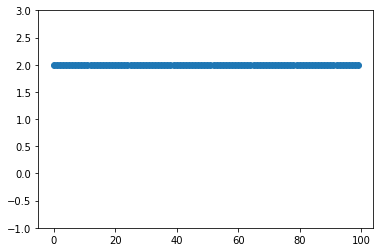

In [8]:
data = []
for i in range(100):
    state = 1 #np.random.choice(3)
    observation = [0,0,0]
    observation[state] = 1
    
    with tf.GradientTape() as tape:
        logits = actor([observation])
        probs = tf.nn.softmax(logits)
        #action = np.random.choice(3, p=probs.numpy()[0])
        action = 2
        data.append(action)
        if action == state:
            adv = 1
        else:
            adv = -1
            
        mask = np.zeros(3)
        mask[action] = adv
        actor_loss = tf.log(probs + 1e-10)*mask
        
    actor_grad_tensors = tape.gradient(actor_loss, actor.trainable_weights)
    actor_grads = [g.numpy() for g in actor_grad_tensors]
    
    for w, ag in zip(actor.trainable_weights, actor_grads):
        w.assign_add(0.01*ag)

plt.ylim(-1,3)
plt.plot(data, 'o')

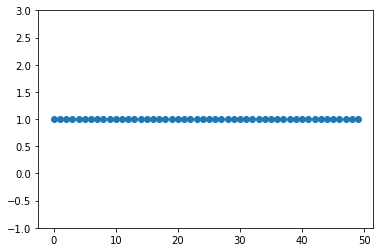

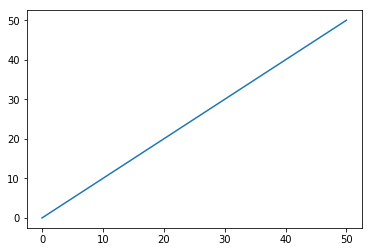

In [9]:
data = []
rews = [0]
for i in range(50):
    state = 1 #np.random.choice(3)
    observation = [0,0,0]
    observation[state] = 1
    # [1,0,0]
    
    with tf.GradientTape() as tape:
        logits = actor([observation])
        probs = tf.nn.softmax(logits)
        action = np.random.choice(3, p=probs.numpy()[0])
        data.append(action)
        if action == state:
            adv = 1
        else:
            adv = -1
            
        rews.append(adv + rews[-1])
        mask = np.zeros(3)
        mask[action] = adv
        actor_loss = tf.log(probs + 1e-10)*mask
        
    actor_grad_tensors = tape.gradient(actor_loss, actor.trainable_weights)
    actor_grads = [g.numpy() for g in actor_grad_tensors]
    
    #for w, ag in zip(actor.trainable_weights, actor_grads):
    #    w.assign_add(0.01*ag)

plt.ylim(-1,3)
plt.plot(data, 'o')
plt.show()

plt.plot(rews)

In [2]:
plotly.offline.iplot({
    "data": [go.Scatter(x=np.arange(len(data)), y=data, mode='markers')],
    "layout": go.Layout(title="Actions Taken")
})

NameError: name 'data' is not defined

In [13]:
from Agent import ActorCriticModel

In [14]:
observations = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

correct_action = np.array([
    [1, 0],
    [0, 1],
    [0, 1],
    [1, 0]
])

class XOREnv:
    def __init__(self, timesteps=10):
        self.action_space = gym.spaces.MultiBinary(1)
        self.observation_space = gym.spaces.Discrete(2)
        
        self.observations = np.array([
            [0, 0],
            [0, 1],
            [1, 0],
            [1, 1]
        ])
        
        self.actions = np.array([
            [1, 0],
            [0, 1],
            [0, 1],
            [1, 0]
        ])
        
        self.timesteps = timesteps

    def reset(self):
        self.timestep = 0
        self.state = np.random.choice(len(self.actions))
        return self.observations[self.state]
    
    def step(self, action):
        if action == np.argmax(self.actions[self.state]):
            reward = 1
        else:
            reward = -1
            
        self.state = np.random.choice(len(self.actions))
        
        self.timestep += 1
        if self.timestep > self.timesteps:
            done = True
        else:
            done = False
            
        if self.timestep + 1 > self.timesteps:
            last_run = True
        else:
            last_run = False
            
        return self.observations[self.state], reward, done, { "last_run": last_run }

In [15]:
class RandomAgent:
    def __init__(self, env):
        self.env = env
        
    def step(self, observation):
        return np.random.choice(self.env.action_space.n)

In [16]:
env = XOREnv()
agent = RandomAgent(env)

obs = agent.env.reset()
done = False
step = 0
rewards = []
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
while not done:
    logging.debug(f"{'step':>13}: {step}")
    action = agent.step(obs)
    logging.debug(f"{'action':>13}: {action}")
    
    next_obs, reward, done, info = agent.env.step(action)
    logging.debug(f"{'next_obs':>13}: {next_obs}")
    logging.debug(f"{'reward':>13}: {reward}")
    logging.debug(f"{'done':>13}: {done}")
    logging.debug(f"{'info':>13}: {info}")
    
    step += 1
    rewards.append(reward)
    total_reward = np.sum(rewards)
    logging.debug(f"{'total_reward':>13}: {total_reward}")
    logging.debug(f"{'...':>13}\n")
    logger.setLevel(logging.INFO)
    
logging.info(" Total Reward: {}".format(np.sum(rewards)))

DEBUG:root:         step: 0
DEBUG:root:       action: 0
DEBUG:root:     next_obs: [1 0]
DEBUG:root:       reward: 1
DEBUG:root:         done: False
DEBUG:root:         info: {'last_run': False}
DEBUG:root: total_reward: 1
DEBUG:root:          ...

INFO:root: Total Reward: 1


In [2]:
from tensorflow.python import keras
from tensorflow.python.keras import layers

class ActorCriticModel(keras.Model):
    def __init__(self, state_size, action_size):
        super(ActorCriticModel, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        
        self.policy_dense_1 = layers.Dense(128, activation='relu')
        self.policy_dense_2 = layers.Dense(128, activation='relu')
        self.policy_logits = layers.Dense(action_size)
        
        self.value_dense_1 = layers.Dense(128, activation='relu')
        self.value_dense_2 = layers.Dense(128, activation='relu')
        self.values = layers.Dense(1)

    def call(self, inputs):
        x = self.policy_dense_1(inputs)
        x = self.policy_dense_2(x)
        logits = self.policy_logits(x)
        
        y = self.value_dense_1(inputs)
        y = self.value_dense_2(y)
        values = self.values(y)
        
        return logits, values
    
class HyperParameters:
    def __init__(self, **kw):
        self.gamma = 0.99
        self.vf_coef = 0.5
        self.ent_coef = 0.01
        self.lr = 0.001
        self.__dict__.update(kw)

In [3]:
def get_log(_v):
    if _v:
        return lambda *args, **kargs: ([None, ] + [[print(f"{arg}") for arg in args] + [print(f"{key}:\t{kargs[key]}") for key in kargs]])[0]
    else:
        return lambda *args, **kargs: None
    
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [12]:
def loss(a2c, observations, actions, discounted_rewards, hyperparameters, verbose=False, *args, **kargs):
    log = get_log(verbose)
    hp = hyperparameters
    
    logits, values = a2c(tf.convert_to_tensor(observations, dtype=tf.float32))
    values = tf.squeeze(values)
    log(logits=logits, actions=actions)

    log(discounted_rewards=discounted_rewards, values=values)
    
    discounted_rewards -= np.mean(discounted_rewards)
    discounted_rewards /= np.std(discounted_rewards)
    log(discounted_rewards_normalized=discounted_rewards)
    
    discounted_rewards = tf.convert_to_tensor(np.array(discounted_rewards), dtype=tf.float32)
    advantages =  tf.stop_gradient(discounted_rewards) - values
    log(advantages=advantages)
    
    critic_loss = advantages ** 2
    log(critic_loss=critic_loss)

    policy = tf.nn.softmax(logits)
    log(policy=policy)
    
    entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=policy, logits=logits)
    log(entropy=entropy)

    actor_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=actions, logits=logits)
    log(actor_loss=actor_loss)
    
    actor_loss *= tf.stop_gradient(advantages)
    log(actor_loss_advs=actor_loss)
    
    actor_loss -= hp.ent_coef * entropy
    log(actor_loss_entropy = actor_loss)

    total_loss = tf.reduce_mean(hp.vf_coef * critic_loss + actor_loss)
    log(total_loss=total_loss)
    log('')
    
    return total_loss

In [13]:
def run(env, a2c, verbose=False, *args, **kargs):
    log = get_log(verbose)
    obs = env.reset()
    done = False
    rewards = []
    actions = []
    observations = []
        
    while not done:
        log(obs=obs)
        
        logits, _ = a2c(tf.convert_to_tensor(obs[None, :], dtype=tf.float32))
        log(logits=logits.numpy()[:3])

        probs = tf.nn.softmax(logits)
        log(probs=probs[0].numpy())

        action = np.random.choice(env.action_space.n, p=probs.numpy()[0])
        log(action=action)

        next_obs, reward, done, info = env.step(action)
        log(next_obs=next_obs, reward=reward, done=done, info=info)
        
        if done:
            reward = -1
        
        observations.append(obs)
        actions.append(action)
        rewards.append(reward)
        
        obs = next_obs
        
        total_reward = np.sum(rewards)
        log(total_reward=total_reward)
        log('')
            
        if done:
            return observations, actions, rewards

In [14]:
def get_discounted_rewards(rewards, gamma=0.99):
    discounted_rewards = []
    reward_sum = 0
    for reward in rewards[::-1]:
        reward_sum = reward + gamma * reward_sum
        discounted_rewards.append(reward_sum)
    discounted_rewards.reverse()
    return discounted_rewards

In [15]:
def learn(a2c, observations, actions, discounted_rewards, hyperparameters, *args, **kargs):
    opt = tf.train.AdamOptimizer(hp.lr, use_locking=True)
    with tf.GradientTape() as tape:
        total_loss = loss(a2c, observations, actions, discounted_rewards, hyperparameters=hp, **kargs)

    grads = tape.gradient(total_loss, a2c.trainable_weights)
    opt.apply_gradients(zip(grads, a2c.trainable_weights))

In [20]:
env = gym.make('CartPole-v0')
#env = gym.make('LunarLander-v2')
a2c = ActorCriticModel(env.observation_space.shape[0], env.action_space.n)
a2c(tf.convert_to_tensor(np.random.random((1, a2c.state_size)), dtype=tf.float32))

(<tf.Tensor: id=891115, shape=(1, 2), dtype=float32, numpy=array([[ 0.03175255, -0.02498347]], dtype=float32)>,
 <tf.Tensor: id=891201, shape=(1, 1), dtype=float32, numpy=array([[-0.19700715]], dtype=float32)>)

In [21]:
hp = HyperParameters(gamma = 0.99, vf_coef = 0.5, ent_coef = 0.01, lr = 0.001)

start_time = time.time()
batch = {
    "observations": [],
    "actions": [],
    "discounted_rewards": []
}

ep_rewards = []
episodes = 100
episode = 0
epochs = 8
batch_size = 512
while episode < episodes:
    observations, actions, rewards = run(env, a2c, verbose=0)
    ep_rewards.append(np.sum(rewards))
    
    # Calculate True Discounted Rewards
    discounted_rewards = get_discounted_rewards(rewards, hp.gamma)
    
    batch['observations'] += observations
    batch['actions'] += actions
    batch['discounted_rewards'] += discounted_rewards

    if len(batch['observations']) >= batch_size:
        print(f"Ep {episode} ({time.time() - start_time:.3f}s): {np.mean(ep_rewards[-10:])}")
        for epoch in range(epochs):
            learn(a2c, hyperparameters=hp, lock_actor=True, **batch)
        batch = {
            "observations": [],
            "actions": [],
            "discounted_rewards": []
        }
    episode += 1
    
end_time = time.time()
print(end_time - start_time)

Ep 19 (0.488s): 24.5
Ep 35 (1.840s): 29.0
Ep 43 (3.247s): 58.1
Ep 48 (4.606s): 80.3
Ep 65 (6.004s): 27.7
Ep 69 (7.396s): 70.7
Ep 77 (8.777s): 74.9
Ep 81 (10.255s): 98.3
Ep 85 (11.800s): 143.3
Ep 90 (13.301s): 135.7
Ep 93 (14.788s): 144.7
Ep 96 (16.320s): 161.3
Ep 99 (17.862s): 185.6
18.83233332633972


In [22]:
observations, actions, rewards = run(env, a2c, verbose=False)
discounted_rewards = get_discounted_rewards(rewards, hp.gamma)
learn(a2c, observations, actions, discounted_rewards, hyperparameters=hp, verbose=True)

logits:	[[-3.32706302e-01  3.60604733e-01]
 [ 7.69595742e-01 -9.79667604e-01]
 [ 1.40035069e+00 -1.78021348e+00]
 [ 7.50568986e-01 -9.51978922e-01]
 [-4.40532714e-01  4.96590346e-01]
 [ 7.39586413e-01 -9.37359810e-01]
 [ 1.40072584e+00 -1.77594030e+00]
 [ 7.67521918e-01 -9.69879806e-01]
 [-3.88486028e-01  4.31984454e-01]
 [ 8.04056942e-01 -1.01574218e+00]
 [-3.24780852e-01  3.53440076e-01]
 [ 8.48622561e-01 -1.07177305e+00]
 [-2.46042013e-01  2.57663876e-01]
 [-1.51901150e+00  1.75723326e+00]
 [-1.91253394e-01  1.90358013e-01]
 [ 9.21573400e-01 -1.16652048e+00]
 [-1.28476009e-01  1.12831905e-01]
 [-1.45930839e+00  1.68828928e+00]
 [-2.40665197e+00  2.77832294e+00]
 [-1.46949852e+00  1.69851410e+00]
 [-2.42271972e+00  2.79819703e+00]
 [-1.52003491e+00  1.75661612e+00]
 [-2.66585618e-01  2.78852791e-01]
 [ 8.00217569e-01 -1.02014601e+00]
 [-3.77163589e-01  4.15575832e-01]
 [ 7.40927100e-01 -9.43287015e-01]
 [-4.72089142e-01  5.34575939e-01]
 [ 6.89240336e-01 -8.76821399e-01]
 [-5.5248308

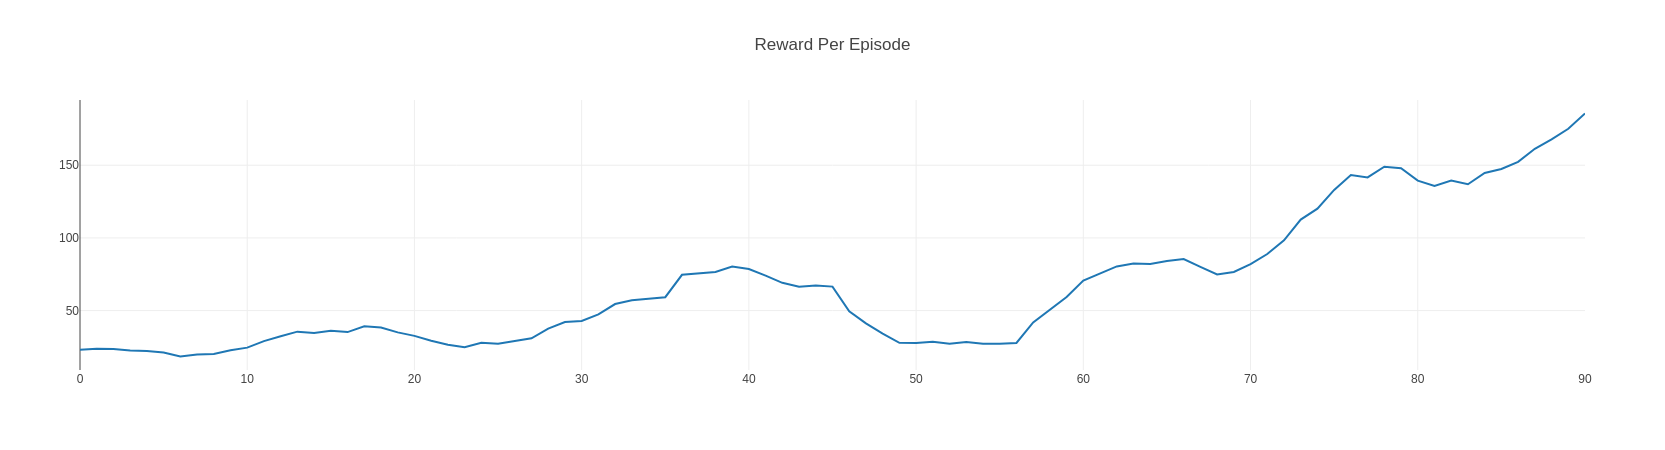

In [25]:
plotly.offline.iplot({
    "data": [go.Scatter(x=np.arange(len(ep_rewards)), y=moving_average(ep_rewards, 10))],
    "layout": go.Layout(title="Reward Per Episode")
})